In [454]:
import folium 
import math
import pandas as pd
import numpy as np
import requests
import geopy.distance
import json
import seaborn as sns
import matplotlib.pyplot as plt

Set up variables needed to query Foursquare. `CLIENT_ID` and `CLIENT_SECRET` are retrieved from a json file which is listed in the `.gitignore` file so that changes to the project can be easly pushed to GitHub with no risk of making these security data public.

In [455]:
CLIENT_ID = 'A'
CLIENT_SECRET = 'B'
with open('week_4_foursquare_connection.json', 'r') as f:
    foursquare_connection = json.load(f)
    CLIENT_ID = foursquare_connection['CLIENT_ID']
    CLIENT_SECRET = foursquare_connection['CLIENT_SECRET']
VERSION = '20200131'
LIMIT = 300
radius = 3000
latitude = 45.7640
longitude = 4.8357
url_format = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'

# Geographic distribution of venues around restaurants

Data from four categories will be retrieved from Foursquare: food (`Food`), fun (`Arts & Entertainment`), school (`College & University`), transport (`Travel & Transport`) and business (`Business Center`)

In [456]:
fun_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'Arts & Entertainment', radius, LIMIT)
fun_json = requests.get(fun_url).json()
school_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'College & University', radius, LIMIT)
school_json = requests.get(school_url).json()
food_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'Food', radius, LIMIT)
food_json = requests.get(food_url).json()
transport_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'Travel & Transport', radius, LIMIT)
transport_json = requests.get(transport_url).json()
business_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'Business Center', radius, LIMIT)
business_json = requests.get(business_url).json()

Retrieved Data from Foursquare are in json, they're transformed to be in dataframe. A field `Category` is added on the go.

In [498]:
data = []
for venues_category, venues_json in [('food', food_json), ('fun', fun_json), ('school', school_json), ('transport', transport_json), ('business', business_json)]:
    for venue in venues_json['response']['venues']:
        address = ''
        if 'address' in venue['location']:
            address = venue['location']['address']
        data.append([venue['name'], venues_category, address, venue['location']['lat'], venue['location']['lng']])
data = pd.DataFrame(data)
data.columns = ['Name', 'Category', 'Address', 'Latitude', 'Longitude']
data.head()

,Name,Category,Address,Latitude,Longitude
0,Halal Burger Chicken Class Food,food,8 rue Sainte Marie des Terreaux,45.767643,4.832869
1,Food Traboule,food,22 rue du Boeuf,45.762966,4.827019
2,Class Food,food,,45.767136,4.833096
3,simple food,food,67 Rue De Marseille,45.767726,4.837527
4,China Fast Food,food,9 rue de l'Ancienne Préfecture,45.760146,4.833297


We're going to measure the distance between places with potential customers and the nearest restaurant. To that end, data are split in two dataframes, `data_food` and `data_else`. The result is added as an extra column, ignore the warning since we know exactly what we're doing here. For `data_food`, the result is always 250, this number is arbitrarily chosen for the sake of looking pretty on the map.

In [471]:
data_food = data[data['Category'] == 'food']
data_else = data[data['Category'] != 'food']
result =[]
for venue in data_else.values:
    distance_min = math.inf
    for food in data_food.values:
        distance_min = min(distance_min, geopy.distance.distance((venue[3], venue[4]), (food[3], food[4])).m)
    result.append(distance_min)
data_else['DistanceToFood'] = result
data_food['DistanceToFood'] = [250] * len(data_food)
venues = pd.concat([data_else, data_food])
venues = venues.sort_values(by='DistanceToFood', ascending=False)
venues.to_csv('week_4_venues.csv', index=False)
venues

C:\_\run\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\_\run\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Name,Category,Address,Latitude,Longitude,DistanceToFood
95,College Charles Senard,school,,45.790664,4.842980,2386.719074
134,Health Club,business,Hilton Lyon Hotel,45.784652,4.853082,1820.112047
105,Business & Decision,business,,45.785110,4.855372,1800.690422
138,Fitness Center @Crowne Plaza,business,,45.785289,4.856860,1785.472094
137,Body Gym Center,business,40 Avenue Henri Barbusse,45.767245,4.879308,1304.989781
...,...,...,...,...,...,...
38,Musée des Beaux-Arts,fun,20 Place des Terreaux,45.766772,4.833712,62.726575
62,Jardins du Palais Saint-Pierre,fun,,45.766804,4.833660,57.352797
41,Quai des Arts,fun,8 bis Quai Saint-Vincent,45.767783,4.817837,44.299869
58,Ensba - Ecole Supérieure Nationale des Beaux A...,fun,18 quai saint vincent,45.767957,4.817419,7.206817


We now display the venues with circles that are the bigger when the venue is the farther from the nearest restaurant. Restaurants, in red, have a fix size.

In [459]:
display = {
    'fun' : { 'color': 'green' },
    'school' : { 'color': 'blue' },
    'transport': { 'color': 'yellow' },
    'business' : { 'color': 'purple' },
    'food' : { 'color': 'red' }
}
map_lyon = folium.Map(location=[latitude, longitude], zoom_start=13)
for name, address, category, lat, lng, dist in zip(venues['Name'], venues['Address'], venues['Category'], venues['Latitude'], venues['Longitude'], venues['DistanceToFood']):
    label = name
    if address != '':
        label = label + ', ' + address
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=dist/50,
        popup=label,
        color=display[category]['color'],
        fill=True,
        fill_color=display[category]['color'],
        fill_opacity=0.7,
        parse_html=False).add_to(map_lyon) 
map_lyon.save("week_4_map.html")
map_lyon

# Categories of restaurants

In [499]:
restaurants = []
for venue in food_json['response']['venues']:
    name = venue['name']
    if 'address' in venue['location']:
        name = name + ', ' + venue['location']['address']
    for category in venue['categories']:
        restaurants.append([name, category['shortName']])
    # print(venue['name'])
restaurants = pd.DataFrame(restaurants)
restaurants.columns = ['NameAddress', 'Category']
restaurants.to_csv('week_4_restaurants.csv', index=False)
restaurants.head()

,NameAddress,Category
0,"Halal Burger Chicken Class Food, 8 rue Sainte ...",Snacks
1,"Food Traboule, 22 rue du Boeuf",Food Court
2,Class Food,Fried Chicken
3,"simple food, 67 Rue De Marseille",Diner
4,"China Fast Food, 9 rue de l'Ancienne Préfecture",Chinese


## Occurences

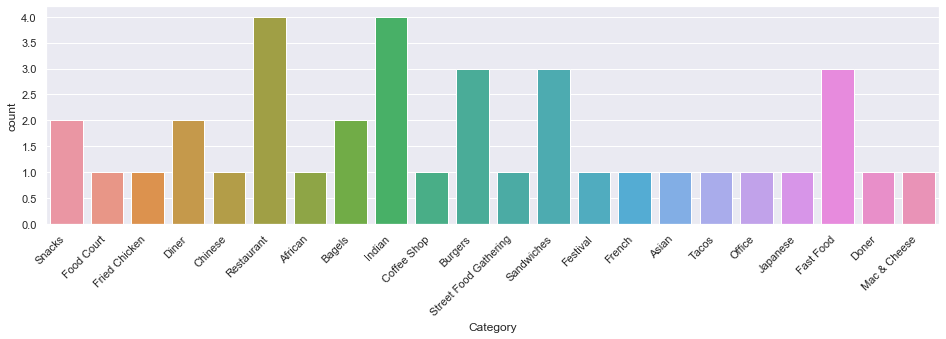

In [468]:
chart = sns.countplot(x="Category", data=restaurants)
sns.set(rc={'figure.figsize':(16,4)})
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.get_figure().savefig("week_4_occurences.png")
chart

In [462]:
## Co-occurences

In [500]:
matrix = []
restaurants_count = restaurants['Category'].unique()
for r1 in restaurants_count:

    matrix_row = [r1]
    for r2 in restaurants_count:

        count = 0
        for i, l1 in restaurants.iterrows():
            for j, l2 in restaurants.iterrows(): 
                if l1['NameAddress'] == l2['NameAddress']  and r1 == l1['Category'] and r2 == l2['Category']:
                    count = count + 1
        matrix_row.append(count)
    matrix.append(matrix_row)
matrix

[['Snacks', 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['Food Court',
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Fried Chicken',
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Diner', 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['Chinese', 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['Restaurant',
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['African', 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['Bagels', 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['Indian', 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['Coffee Shop',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Burgers', 

In [501]:
matrixdf = pd.DataFrame(matrix)
columns = restaurants_count.tolist() 
columns.insert(0, 'Category')
matrixdf.columns = columns
matrixdf = matrixdf.set_index('Category')
matrixdf

,Snacks,Food Court,Fried Chicken,Diner,Chinese,Restaurant,African,Bagels,Indian,Coffee Shop,...,Sandwiches,Festival,French,Asian,Tacos,Office,Japanese,Fast Food,Doner,Mac & Cheese
Category,,,,,,,,,,,,,,,,,,,,,
Snacks,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Food Court,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fried Chicken,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Diner,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chinese,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Restaurant,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
African,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bagels,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Indian,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0


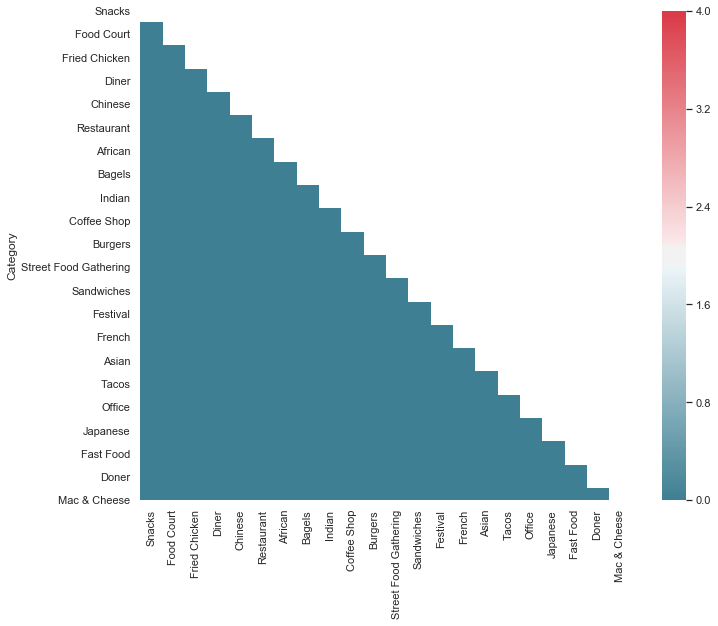

In [502]:
sns.set(style="white")
# Compute the correlation matrix
corr = matrixdf
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrixdf, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
chart = sns.heatmap(matrixdf, mask=mask, cmap=cmap)
chart.get_figure().savefig("week_4_cooccurences.png")
chart

It's disapointing but it turns out that there are no co-occurences, every restaurant belongs to a single category, something I could have find out more easly.